In [60]:

import re
import os
import sys
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import networkx as nx
import pybedtools as bt
from scipy import stats

from scipy.spatial import distance
from scipy.cluster import hierarchy

from scipy.stats import spearmanr
from adjustText import adjust_text



import matplotlib.patches as mpatches
import matplotlib.collections as mcol

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec
from matplotlib.lines import Line2D
from mycolorpy import colorlist as mcp

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib_venn import venn2

color1=mcp.gen_color(cmap="Reds",n=10)[-7:-2]
color2=mcp.gen_color(cmap="Greys",n=10)[-5:]
color3=mcp.gen_color(cmap="Oranges",n=10)[-7:-2]
color4=mcp.gen_color(cmap="Greens",n=10)[-7:-2]
sns.set(style="ticks", font_scale=2)

mcp.gen_color(cmap="Purples",n=10)[-7:-2]

def flatten(l):
    return [item for sublist in l for item in sublist]




BEDPRO = pickle.load(open('data/P/BEDPRO.p', 'rb'))

# N contains BW signal for RNA seq but BEDPRO contains  
N = pd.read_table('data/TABLE/Epigenome.tmm.tsv').set_index('Name').drop_duplicates()

MAPty = pickle.load(open('data/MAP/MAPty.p', 'rb')) 
MAPcl = pickle.load(open('data/MAP/MAPcl.p', 'rb'))
MAPgn = pickle.load(open('data/MAP/MAPgn.p', 'rb'))

H = pickle.load(open('data/G/G_ALL.p', 'rb'))



np.random.seed(7)
andr = [n for n, nc in MAPcl.items() if nc == 'ANDR']
#high = np.random.choice([n for n, nc in MAPcl.items() if nc == 'High'], size=len(andr))
high = np.random.choice([n for n, nc in MAPcl.items() if nc == 'High' if (n in H) and (len(list(nx.bfs_layers(H, n))) > 1)], size=len(andr), replace=False)
midh = np.random.choice([n for n, nc in MAPcl.items() if nc == 'Mid-high' if (n in H) and (len(list(nx.bfs_layers(H, n))) > 1)], size=len(andr), replace=False)
len(high), len(midh), len(andr)

(89, 89, 89)

In [52]:

def calculateC(geneset, s,  to=None, verbose=False):
	global MAPcl
	global H
	I = {
		n:list(nx.bfs_layers(H, n))[1]
		for n in geneset
		if n in H
		if len(list(nx.bfs_layers(H, n))) > 1
	}

	if to is None:
		to = list(set(MAPcl.values()))

	A = []
	for p,es in I.items():
		for e in es:
			if MAPcl[e] in to:
				d = H.get_edge_data(p, e)
				l = [d[k] for k in [f"{s}.0m",f"{s}.30m",f"{s}.4h", f"{s}.16h", f"{s}.72h"]]

				A += [l]

	c1 = pd.DataFrame(np.array(A), columns=["0m", "30m","4h", "16h", "72h"])

	if verbose:
		print(f'ANDR G: {len(I)}')
		print(f'ANDR G -> {to}: {len(A)}')
	return c1


# Promoter

In [58]:


c1 = calculateC(andr, 'H3K27ac', verbose=True)
hh = calculateC(high, 'H3K27ac', verbose=True)


BOOT = 100
FC1_H3K27ac = np.zeros((BOOT, 5))
FC2_H3K27ac = np.zeros((BOOT, 5))
#for j, s in enumerate(['H3K27ac', 'H3K4me3']):
####################################
np.random.seed(7)
for i in range(BOOT):
    geneset = np.random.choice(BEDPRO.loc[(BEDPRO['Quartile'] == 'High'), 'Name'].tolist(), size=100)
    tmp = calculateC(geneset, 'H3K27ac', ['cre'])

    FC1_H3K27ac[i,:] = c1.mean(0) / tmp.mean(0) 
    FC2_H3K27ac[i,:] = hh.mean(0) / tmp.mean(0)
            



c1 = calculateC(andr, 'H3K4me3', verbose=True)
hh = calculateC(high, 'H3K4me3', verbose=True)


BOOT = 100
FC1_H3K4me3 = np.zeros((BOOT, 5))
FC2_H3K4me3 = np.zeros((BOOT, 5))
#for j, s in enumerate(['H3K27ac', 'H3K4me3']):
####################################
np.random.seed(7)
for i in range(BOOT):
    geneset = np.random.choice(BEDPRO.loc[(BEDPRO['Quartile'] == 'High'), 'Name'].tolist(), size=100)
    tmp = calculateC(geneset, 'H3K4me3', ['cre'])

    FC1_H3K4me3[i,:] = c1.mean(0) / tmp.mean(0) 
    FC2_H3K4me3[i,:] = hh.mean(0) / tmp.mean(0)
            


ANDR G: 88
ANDR G -> ['Mid-low', 'cre', 'low', 'ANDR', 'High', 'ARcre', 'Mid-high']: 1648
ANDR G: 89
ANDR G -> ['Mid-low', 'cre', 'low', 'ANDR', 'High', 'ARcre', 'Mid-high']: 1954
ANDR G: 88
ANDR G -> ['Mid-low', 'cre', 'low', 'ANDR', 'High', 'ARcre', 'Mid-high']: 1648
ANDR G: 89
ANDR G -> ['Mid-low', 'cre', 'low', 'ANDR', 'High', 'ARcre', 'Mid-high']: 1954


Text(0.5, 0, '')

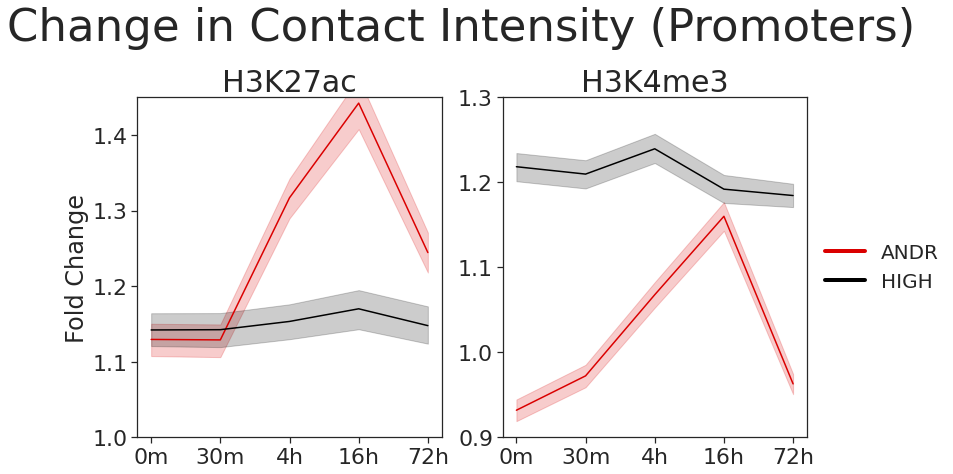

In [59]:

fig = plt.figure(figsize=[12,7])
gs = gridspec.GridSpec(nrows=1, ncols=2, top=0.8)

fig.add_subplot(gs[0])
tmp1 = pd.DataFrame(np.array(FC1_H3K27ac), columns=["0m", "30m","4h", "16h", "72h"])
tmp1 = tmp1.stack().reset_index()
sns.lineplot(data=tmp1, x='level_1',y=0, color='#DA0000')
tmp2 = pd.DataFrame(np.array(FC2_H3K27ac), columns=["0m", "30m","4h", "16h", "72h"])
tmp2 = tmp2.stack().reset_index()
sns.lineplot(data=tmp2, x='level_1',y=0, color='#000000')

plt.ylim(1, 1.45)


plt.title(f"H3K27ac", fontsize=30)


plt.ylabel("Fold Change")

plt.xlabel('')

fig.add_subplot(gs[1])
tmp1 = pd.DataFrame(np.array(FC1_H3K4me3), columns=["0m", "30m","4h", "16h", "72h"])
tmp1 = tmp1.stack().reset_index()
sns.lineplot(data=tmp1, x='level_1',y=0, color='#DA0000')
tmp2 = pd.DataFrame(np.array(FC2_H3K4me3), columns=["0m", "30m","4h", "16h", "72h"])
tmp2 = tmp2.stack().reset_index()
sns.lineplot(data=tmp2, x='level_1',y=0, color='#000000')

plt.ylim(0.9, 1.3)


plt.title(f"H3K4me3", fontsize=30)


handles = [Line2D([0], [0], color="#DA0000", lw=4),Line2D([0], [0], color="#000000", lw=4)]
plt.legend(handles,  [f"ANDR",f"HIGH"],loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, fontsize=20)



fig.suptitle('Change in Contact Intensity (Promoters)', fontsize=45)


plt.ylabel('')
plt.xlabel('')

#fig.savefig('plots/contactChangePromoter.pdf', bbox_inches ="tight",  pad_inches = 1 )

# Enhancer

In [56]:


c1 = calculateC(andr, 'H3K27ac', ['ARcre'], verbose=True)
c2 = calculateC(andr, 'H3K27ac', ['cre'], verbose=True)
hh = calculateC(high, 'H3K27ac', ['cre'], verbose=True)


BOOT = 100
FC1_H3K27ac = np.zeros((BOOT, 5))
FC2_H3K27ac = np.zeros((BOOT, 5))
FC3_H3K27ac = np.zeros((BOOT, 5))
#for j, s in enumerate(['H3K27ac', 'H3K4me3']):
####################################
np.random.seed(7)
for i in range(BOOT):
    geneset = np.random.choice(BEDPRO.loc[(BEDPRO['Quartile'] == 'High'), 'Name'].tolist(), size=100)
    tmp = calculateC(geneset, 'H3K27ac', ['cre'])

    FC1_H3K27ac[i,:] = c1.mean(0) / tmp.mean(0)
    FC2_H3K27ac[i,:] = c2.mean(0) / tmp.mean(0)
    FC3_H3K27ac[i,:] = hh.mean(0) / tmp.mean(0)
            



c1 = calculateC(andr, 'H3K4me3', ['ARcre'], verbose=True)
c2 = calculateC(andr, 'H3K4me3', ['cre'], verbose=True)
hh = calculateC(high, 'H3K4me3', ['cre'], verbose=True)


BOOT = 100
FC1_H3K4me3 = np.zeros((BOOT, 5))
FC2_H3K4me3 = np.zeros((BOOT, 5))
FC3_H3K4me3 = np.zeros((BOOT, 5))
#for j, s in enumerate(['H3K27ac', 'H3K4me3']):
####################################
for i in range(BOOT):
    geneset = np.random.choice(BEDPRO.loc[(BEDPRO['Quartile'] == 'High'), 'Name'].tolist(), size=100)
    tmp = calculateC(geneset, 'H3K4me3', ['cre'])

    FC1_H3K4me3[i,:] = c1.mean(0) / tmp.mean(0) 
    FC2_H3K4me3[i,:] = c2.mean(0) / tmp.mean(0) 
    FC3_H3K4me3[i,:] = hh.mean(0) / tmp.mean(0)
            


ANDR G: 88
ANDR G -> ['ARcre']: 233
ANDR G: 88
ANDR G -> ['cre']: 923
ANDR G: 89
ANDR G -> ['cre']: 920
ANDR G: 88
ANDR G -> ['ARcre']: 233
ANDR G: 88
ANDR G -> ['cre']: 923
ANDR G: 89
ANDR G -> ['cre']: 920


Text(0.5, 0, '')

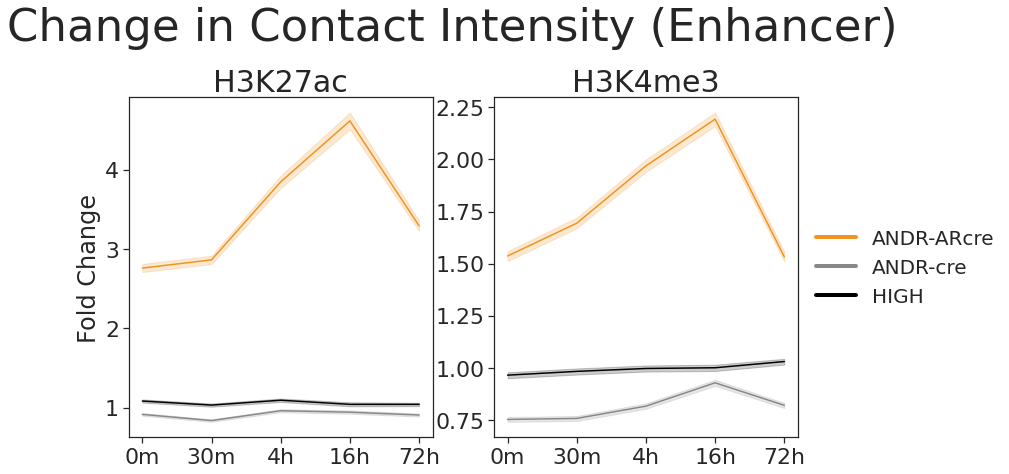

In [57]:

fig = plt.figure(figsize=[12,7])
gs = gridspec.GridSpec(nrows=1, ncols=2, top=0.8)

fig.add_subplot(gs[0])
tmp1 = pd.DataFrame(np.array(FC1_H3K27ac), columns=["0m", "30m","4h", "16h", "72h"])
tmp1 = tmp1.stack().reset_index()
sns.lineplot(data=tmp1, x='level_1',y=0, color='#F19321')
tmp2 = pd.DataFrame(np.array(FC2_H3K27ac), columns=["0m", "30m","4h", "16h", "72h"])
tmp2 = tmp2.stack().reset_index()
sns.lineplot(data=tmp2, x='level_1',y=0, color='#888888')
tmp3 = pd.DataFrame(np.array(FC3_H3K27ac), columns=["0m", "30m","4h", "16h", "72h"])
tmp3 = tmp3.stack().reset_index()
sns.lineplot(data=tmp3, x='level_1',y=0, color='#000000')

#plt.ylim(0.95, 1.3)


plt.title(f"H3K27ac", fontsize=30)


plt.ylabel("Fold Change")

plt.xlabel('')

fig.add_subplot(gs[1])
tmp1 = pd.DataFrame(np.array(FC1_H3K4me3), columns=["0m", "30m","4h", "16h", "72h"])
tmp1 = tmp1.stack().reset_index()
sns.lineplot(data=tmp1, x='level_1',y=0, color='#F19321')
tmp2 = pd.DataFrame(np.array(FC2_H3K4me3), columns=["0m", "30m","4h", "16h", "72h"])
tmp2 = tmp2.stack().reset_index()
sns.lineplot(data=tmp2, x='level_1',y=0, color='#888888')
tmp3 = pd.DataFrame(np.array(FC3_H3K4me3), columns=["0m", "30m","4h", "16h", "72h"])
tmp3 = tmp3.stack().reset_index()
sns.lineplot(data=tmp3, x='level_1',y=0, color='#000000')

#plt.ylim(0.7, 1)


plt.title(f"H3K4me3", fontsize=30)


handles = [Line2D([0], [0], color="#F19321", lw=4), Line2D([0], [0], color="#888888", lw=4), Line2D([0], [0], color="#000000", lw=4)]
plt.legend(handles,  ["ANDR-ARcre","ANDR-cre","HIGH"],loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, fontsize=20)



fig.suptitle('Change in Contact Intensity (Enhancer)', fontsize=45)


plt.ylabel('')
plt.xlabel('')

#fig.savefig('plots/contactChangeEnhancer.pdf', bbox_inches ="tight",  pad_inches = 1 )

# Down regulated

In [68]:
down = pickle.load(open('data/P/downgenes.p', 'rb'))


c1 = calculateC(down, 'H3K27ac', ['ARcre'], verbose=True)
hh = calculateC(high, 'H3K27ac', ['cre'], verbose=True)


BOOT = 100
FC1_H3K27ac = np.zeros((BOOT, 5))
FC2_H3K27ac = np.zeros((BOOT, 5))
#for j, s in enumerate(['H3K27ac', 'H3K4me3']):
####################################
np.random.seed(7)
for i in range(BOOT):
    geneset = np.random.choice(BEDPRO.loc[(BEDPRO['Quartile'] == 'High'), 'Name'].tolist(), size=100)
    tmp = calculateC(geneset, 'H3K27ac', ['cre'])

    FC1_H3K27ac[i,:] = c1.mean(0) / tmp.mean(0)
    FC2_H3K27ac[i,:] = hh.mean(0) / tmp.mean(0)
            

c1 = calculateC(down, 'H3K4me3', ['ARcre'], verbose=True)
hh = calculateC(high, 'H3K4me3', ['cre'], verbose=True)


BOOT = 100
FC1_H3K4me3 = np.zeros((BOOT, 5))
FC2_H3K4me3 = np.zeros((BOOT, 5))
#for j, s in enumerate(['H3K27ac', 'H3K4me3']):
####################################
for i in range(BOOT):
    geneset = np.random.choice(BEDPRO.loc[(BEDPRO['Quartile'] == 'High'), 'Name'].tolist(), size=100)
    tmp = calculateC(geneset, 'H3K4me3', ['cre'])

    FC1_H3K4me3[i,:] = c1.mean(0) / tmp.mean(0) 
    FC2_H3K4me3[i,:] = hh.mean(0) / tmp.mean(0)
            


ANDR G: 34
ANDR G -> ['ARcre']: 39
ANDR G: 89
ANDR G -> ['cre']: 920
ANDR G: 34
ANDR G -> ['ARcre']: 39
ANDR G: 89
ANDR G -> ['cre']: 920


Text(0.5, 0, '')

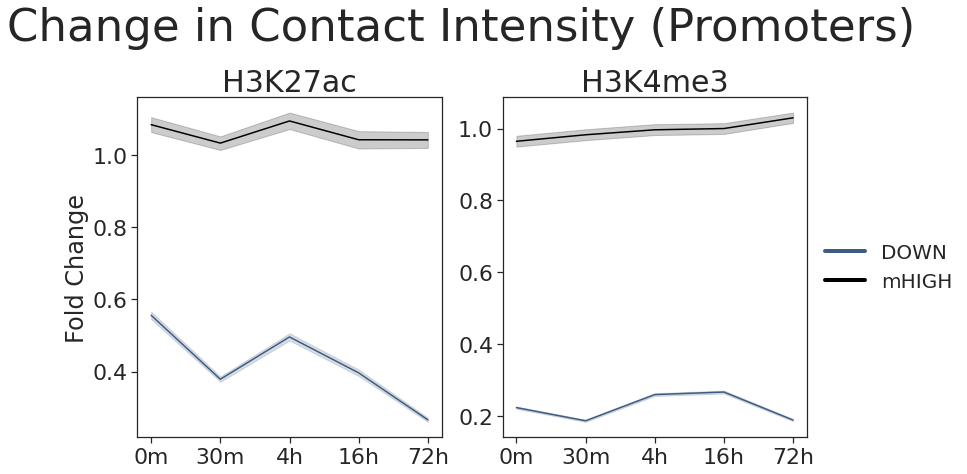

In [69]:

fig = plt.figure(figsize=[12,7])
gs = gridspec.GridSpec(nrows=1, ncols=2, top=0.8)

fig.add_subplot(gs[0])
tmp1 = pd.DataFrame(np.array(FC1_H3K27ac), columns=["0m", "30m","4h", "16h", "72h"])
tmp1 = tmp1.stack().reset_index()
sns.lineplot(data=tmp1, x='level_1',y=0, color='#3E5B81')
tmp2 = pd.DataFrame(np.array(FC2_H3K27ac), columns=["0m", "30m","4h", "16h", "72h"])
tmp2 = tmp2.stack().reset_index()
sns.lineplot(data=tmp2, x='level_1',y=0, color='#000000')



plt.title(f"H3K27ac", fontsize=30)


plt.ylabel("Fold Change")

plt.xlabel('')

fig.add_subplot(gs[1])
tmp1 = pd.DataFrame(np.array(FC1_H3K4me3), columns=["0m", "30m","4h", "16h", "72h"])
tmp1 = tmp1.stack().reset_index()
sns.lineplot(data=tmp1, x='level_1',y=0, color='#3E5B81')
tmp2 = pd.DataFrame(np.array(FC2_H3K4me3), columns=["0m", "30m","4h", "16h", "72h"])
tmp2 = tmp2.stack().reset_index()
sns.lineplot(data=tmp2, x='level_1',y=0, color='#000000')



plt.title(f"H3K4me3", fontsize=30)


handles = [Line2D([0], [0], color="#3E5B81", lw=4),Line2D([0], [0], color="#000000", lw=4)]
plt.legend(handles,  [f"DOWN",f"mHIGH"],loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, fontsize=20)



fig.suptitle('Change in Contact Intensity (Promoters)', fontsize=45)


plt.ylabel('')
plt.xlabel('')

#fig.savefig('plots/contactChangePromoter.pdf', bbox_inches ="tight",  pad_inches = 1 )

# Gini index

In [ ]:

import numpy as np

np.random.seed(7)
def gini_coefficient(x):
    x.sort()
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        #print(f"{xi} - {x[i:]}")
        diffsum += np.sum(np.abs(xi - x[i:]))
        #break
    return diffsum / (len(x)**2 * np.mean(x))


v = np.random.rand(50)

gini_coefficient(v)